In [3]:
import time
import pyspark.sql.functions as f
from dateutil.parser import parse
from pyspark.sql.functions import lit as lit, udf as udf, count as count, date_format as date_format, col, month
from pyspark.sql.types import DoubleType, StringType
from datetime import datetime
from numpy import array
from uszipcode import SearchEngine
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SQLContext, Row
from pyspark import SparkContext
start = time.time()

sqlc = SQLContext(sc)

In [4]:
df = sqlc.read.csv(
    's3a://chictaxi/chictaxi.csv', 
    header='true', inferSchema='true')

df.repartition(62)

print('Q1')
# 1a. How many taxi records are there?

print(f'Total number of records: {df.count()}')


norm_col_names_df = df.select(
    [f.col(col).alias(col.replace(' ', '_').replace('__', '_')) for col in df.columns])

ext_norm_col_names_df = norm_col_names_df \
                            .select(f.col('Trip_ID').alias('tripId'),
                                    f.col('Taxi_ID').alias('taxiId'),
                                    f.col('Trip_Start_Timestamp').alias('startTimestamp'),
                                    f.col('Trip_End_Timestamp').alias('endTimestamp'),
                                    f.col('Trip_Seconds').alias('seconds'),
                                    f.col('Trip_Miles').alias('miles'),
                                    f.col('Fare').alias('fare'),
                                    f.col('Tips').alias('tips'),
                                    f.col('Tolls').alias('tolls'),
                                    f.col('Extras').alias('extras'),
                                    f.col('Trip_Total').alias('tripTotal'),
                                    f.col('Pickup_Centroid_Latitude').alias('pickupCentroidLat'),
                                    f.col('Pickup_Centroid_Longitude').alias('pickupCentroidLong'),
                                    f.col('Dropoff_Centroid_Latitude').alias('dropoffCentroidLat'),
                                    f.col('Dropoff_Centroid_Longitude').alias('dropoffCentroidLong')) \
                            .withColumn('startTimestampDt', f.to_timestamp(f.col('startTimestamp'), 'MM/dd/yyyy hh:mm:ss a')) \
                            .withColumn('endTimestampDt', f.to_timestamp(f.col('endTimestamp'), 'MM/dd/yyyy hh:mm:ss a')) \
                            .withColumn('startTimestampYear', f.year(f.to_timestamp(f.col('startTimestamp'), 'MM/dd/yyyy hh:mm:ss a')))


cleaned_taxi_df = ext_norm_col_names_df.dropna(subset=['tripId', 
                                                        'taxiId', 
                                                        'seconds', 
                                                        'miles', 
                                                        'fare',
                                                        'startTimestamp',
                                                        'endTimestamp',
                                                        'pickupCentroidLat',
                                                        'pickupCentroidLong',
                                                        'dropoffCentroidLat',
                                                        'dropoffCentroidLong'
                                                       ]).dropDuplicates()

print(f'Number of records left after clean up: {cleaned_taxi_df.count()}')

cleaned_taxi_df.registerTempTable('all_taxi_records')
sqlc.cacheTable('all_taxi_records')
# Assumption: Records for year are based on the start timestamp

all_taxi_record_count_by_start_year = sqlc.sql('SELECT startTimestampYear AS year, count(tripId) AS count \
                                               FROM all_taxi_records \
                                               GROUP BY startTimestampYear \
                                               ORDER BY startTimestampYear')
print('Number of records per year')
all_taxi_record_count_by_start_year.show()

print('Q2')
# 2a. Number of records classified as bad:

bad_record_count = sqlc.sql('SELECT count(tripId) AS bad_records_count \
                            FROM all_taxi_records \
                            WHERE (seconds < 60) \
                                    OR ((miles / (seconds / 3600)) > 100) \
                                    OR (miles > 1000) \
                                    OR (fare > 2000)')
print(f'Number of bad records')
bad_record_count.show()

# 2b. Number of good records by year:

good_records = sqlc.sql('SELECT * FROM all_taxi_records \
                        WHERE (seconds >= 60) \
                                AND ((miles / (seconds / 3600)) <= 100) \
                                AND (miles <= 1000) \
                                AND (fare <= 2000)')

good_records.registerTempTable('taxi')
sqlc.cacheTable('taxi')

print('Number of good records per year')
good_records_by_year = sqlc.sql('SELECT startTimestampYear AS year, COUNT(*) AS count \
                                FROM taxi \
                                GROUP BY startTimestampYear \
                                ORDER BY startTimestampYear').show()


print('Q3')
# 3a. Average revenue (Fare + Tips) per day for each taxi excluding tolls:
good_records_for_2018 = sqlc.sql('SELECT *, (taxi.fare + taxi.tips) AS revenue \
                                FROM taxi \
                                WHERE startTimestampYear = 2018')
good_records_for_2018.registerTempTable('taxi_2018')
sqlc.cacheTable('taxi_2018')

total_revenue_per_taxi = sqlc.sql('SELECT taxiId, sum(revenue) AS total_revenue \
                                FROM taxi_2018 \
                                GROUP BY taxiId')
total_revenue_per_taxi.registerTempTable('taxi_2018_revenue')
average_revenue_per_taxi = sqlc.sql('SELECT taxiId, (total_revenue/365) AS daily_average \
                                    FROM taxi_2018_revenue')

print('Average revenue per day excluding tolls')
average_revenue_per_taxi.show(5)



# 3b. The most successful taxi in 2018 in terms of total revenue (Fare + Tips)

print('The most successful taxi in 2018 in terms of revenue')
total_revenue_per_taxi.orderBy('total_revenue', ascending=False).show(1)


print('Q4')
# 4a. The average speed of taxis during each period:
# Assumption: The solution below assumes that the midpoint refers to the midpoint of the start timestamp and end timestamp, rather than that of the distance between the pickup and dropoff locations.

# Calculates the midpoint between start and end timestamps
mid_point = lambda startTimestamp, endTimestamp: startTimestamp + (endTimestamp - startTimestamp) / 2

hourly_record = good_records_for_2018 \
                            .withColumn('startPeriod', f.hour(f.col('startTimestampDt'))) \
                            .withColumn('endPeriod', f.hour(f.col('endTimestampDt'))) \
                            .withColumn('boundaryCrossed', f.col('startPeriod') != f.col('endPeriod')) \
                            .withColumn('midPoint', f.to_timestamp(mid_point(f.col('startTimestampDt'), f.col('endTimestampDt')), 'MM/dd/yyyy hh:mm:ss a')) \
                            .withColumn('assignedPeriod', 
                                        f.when(f.col('boundaryCrossed') == True, f.hour(f.col('midPoint')))
                                        .otherwise(f.col('startPeriod'))
                            )


hourly_record.registerTempTable('hourly_record')
sqlc.cacheTable('hourly_record')

hourly_speed = sqlc.sql('SELECT assignedPeriod AS hour_of_day, (SUM(miles) / (SUM(seconds)/3600)) AS `avg_speed (mph)` \
                        FROM hourly_record \
                        GROUP BY hour_of_day \
                        ORDER BY hour_of_day')

print('The average speed of taxis during each period')
hourly_speed.show(24)


# 4b. The period where drivers earn the most money in total in terms of fares:

hourly_fare = sqlc.sql('SELECT assignedPeriod AS hour_of_day, SUM(fare) AS `fares` \
                                FROM hourly_record \
                                GROUP BY hour_of_day \
                                ORDER BY `fares` DESC')

print('The period where drivers earn the most money in total in terms of fares')
hourly_fare.show(24)


# 4c. The period of the day where drivers in total earn the most in tips:


hourly_tips = sqlc.sql('SELECT assignedPeriod AS hour_of_day, SUM(tips) AS `tips ($)` \
                                FROM hourly_record \
                                GROUP BY hour_of_day \
                                ORDER BY `tips ($)` DESC')
print('The period of the day where drivers in total earn the most in tips')
hourly_tips.show(24)

print('Q5')
# 5a. The overall percentage of tips that drivers get excluding tolls and extras (i.e. Fare + Tips):

overall_percentage_of_tips = sqlc.sql('SELECT SUM(tips) AS `total_tips ($)`, \
                                        SUM(fare + tips) AS `total_revenue ($)`, \
                                        (SUM(tips)/SUM(fare + tips)) * 100 AS `overall_tips (%)` \
                                        FROM hourly_record')
print(f'Overall percentage tips drivers get excl. tolls and extras is as follows:')
overall_percentage_of_tips.show()


# 5b. The top ten trips with the best tip per distance travelled:

trips_by_tips_per_distance = sqlc.sql('SELECT tripId AS tripId, tips AS `tips ($)`, \
                                        miles AS `distance (m)`, \
                                        tips/miles AS `tip_per_distance ($ per mile)` \
                                        FROM taxi_2018 \
                                        ORDER BY `tip_per_distance ($ per mile)` DESC')
print('Top ten trips with the best tip per distance travelled:')
trips_by_tips_per_distance.show(10)




Q1
Total number of records: 193836156
Number of records left after clean up: 165840914
Number of records per year
+----+--------+
|year|   count|
+----+--------+
|2013|21667463|
|2014|32021348|
|2015|27319043|
|2016|26728237|
|2017|22067753|
|2018|18762161|
|2019|14683969|
|2020| 2590940|
+----+--------+

Q2
Number of bad records
+-----------------+
|bad_records_count|
+-----------------+
|          5823543|
+-----------------+

Number of good records per year
+----+--------+
|year|   count|
+----+--------+
|2013|20766221|
|2014|30963026|
|2015|26438041|
|2016|25570429|
|2017|21307031|
|2018|18180878|
|2019|14282067|
|2020| 2509678|
+----+--------+

Q3
Average revenue per day excluding tolls
+--------------------+------------------+
|              taxiId|     daily_average|
+--------------------+------------------+
|074ebefb524b3c9c3...|161.74947945205486|
|d06d9962fe86645dd...|162.87783561643838|
|d2c2d4128d6597a3b...| 239.7766301369863|
|bdba06f86d8822d4d...|134.49641095890414|
|cb45

Average tip percentage by month for the whole period
+-----+------------------+--------------------+------------------+
|month|         total_tip|       total_revenue|       average_tip|
+-----+------------------+--------------------+------------------+
|    1|2238542.7899999996|1.9483139510000005E7|11.489641024492151|
|    2|2209597.3800000004|       1.941533287E7|11.380682447192058|
|    3|        2693401.92|2.4290486780000005E7|11.088299482815055|
|    4|2795060.8400000003|2.4465562140000008E7| 11.42447013481947|
|    5|2988846.8699999973|2.6278181020000003E7|11.373872749126823|
|    6| 3138382.299999999|2.7162654700000007E7| 11.55403378153608|
|    7|         2352237.7|2.2029870700000007E7|10.677492083510048|
|    8|2548280.5300000003|2.3134379269999996E7|11.015123856400756|
|    9|2501967.9899999993|       2.231115591E7|11.213977438428465|
|   10| 2952165.269999999|2.5437660400000002E7|11.605490534813487|
|   11|2466786.2699999996|2.1562168850000013E7|11.440343905849703|
|   12|  

<IPython.core.display.Javascript object>


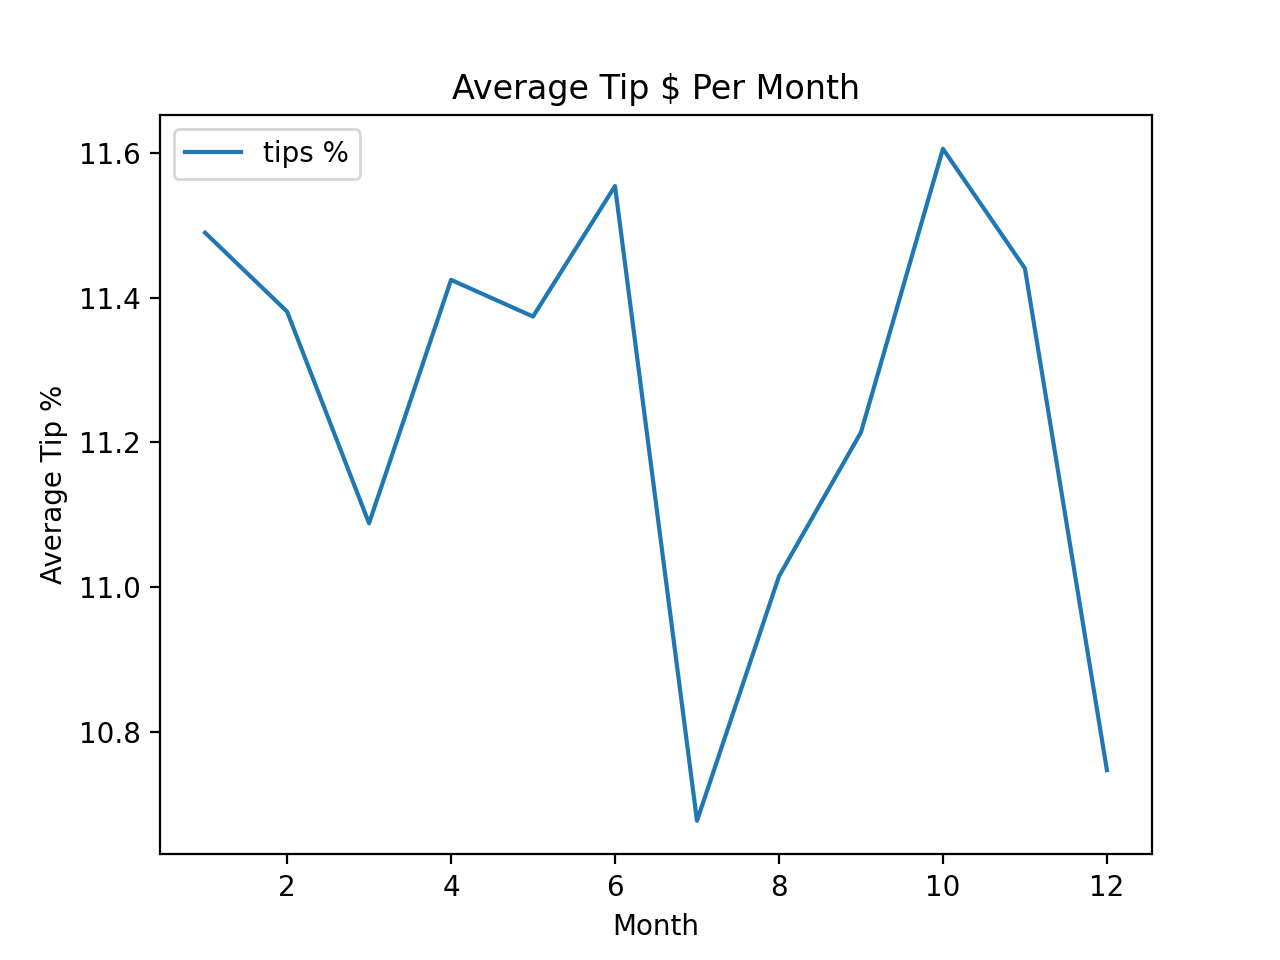

Q6
The best 5 locations for a driver to start a trip on a weekday evening between 5 - 7 pm:
41.97931632455779,-87.90463576965965
41.881168059808886,-87.63844922500306
41.78840450394002,-87.7522016008575
41.89758393218012,-87.63000386704037
41.87811359894621,-87.62062747393927
41.95815779351264,-87.67469897670226


In [5]:
# 5c. Graph of average tip percentage by month for the whole period:

average_tip_percentage_by_month = good_records_for_2018 \
    .select(
        f.col('tips'), 
        f.col('startTimestampDt').alias('startTimestamp'),
        f.col('fare')) \
        .withColumn('month', f.month(f.col('startTimestamp'))) \
        .withColumn('revenue', f.col('fare') + f.col('tips')) \
        .groupBy('month').agg(
            f.sum('tips').alias('total_tip'), 
            f.sum('revenue').alias('total_revenue')) \
        .withColumn('average_tip', 100 * (f.col('total_tip') / f.col('total_revenue'))) \
        .orderBy('month')
print('Average tip percentage by month for the whole period')
average_tip_percentage_by_month.show()


%matplotlib notebook
import matplotlib.pyplot as plt

y= [val.average_tip for val in average_tip_percentage_by_month.select('average_tip').collect()]
x = [val.month for val in average_tip_percentage_by_month.select('month').collect()]

plt.plot(x, y)

plt.ylabel('Average Tip %')
plt.xlabel('Month')
plt.title('Average Tip $ Per Month')
plt.legend(['tips %'], loc='upper left')
plt.show()

print('Q6')

# 6. The best 5 locations for a driver to start a trip on a weekday evening between 5 - 7 pm:

weekday_locations = sqlc.sql('SELECT date_format(startTimestampDt, "E") AS `day_of_week`, \
                            startPeriod, \
                            pickupCentroidLat AS Y, \
                            pickupCentroidLong AS X \
                            FROM hourly_record \
                            WHERE date_format(startTimestampDt, "E") NOT IN ("Sat", "Sun")                                  AND startPeriod >= 17 AND startPeriod <= 19')

weekday_geo_location = weekday_locations.rdd.map(lambda row: array([row.Y, row.X]))

num_clusters=6
clusters = KMeans.train(weekday_geo_location, num_clusters, maxIterations=10, initializationMode="random")

print('The best 5 locations for a driver to start a trip on a weekday evening between 5 - 7 pm:')
for arr in clusters.centers:
    list = arr.tolist()
    print(str(list[0]) +","+ str(list[1]))


In [6]:
# good_records_for_2018.write.mode('overwrite').parquet('tmp/good_records_for_2018')

# hourly_fare.write.mode('overwrite').parquet('tmp/hourly_fare')

In [7]:

# 7. The most common pair of zipcodes to start/stop a journey in:


# Search zipcode for given coordinates within 30 miles
zip_code_coord = lambda Y, X: None if((Y is None) or (X is None)) else SearchEngine(simple_zipcode=True).by_coordinates(Y, X, radius=30, returns=1)[0].zipcode

zip_codes = good_records_for_2018.rdd.map(lambda r: 
                              Row(Y1 = r.pickupCentroidLat,
                                  X1 = r.pickupCentroidLong,
                                  Y2 = r.dropoffCentroidLat,
                                  X2 = r.dropoffCentroidLong,
                                  startZipCode = zip_code_coord(r.pickupCentroidLat, r.pickupCentroidLong),
                                  stopZipCode = zip_code_coord(r.dropoffCentroidLat, r.dropoffCentroidLong)
                                 )
                             ).toDF()

# good_records_for_2018_tmp = sqlc.read.parquet('tmp/good_records_for_2018')

# zip_codes = good_records_for_2018_tmp.rdd.map(lambda r: 
#                               Row(Y1 = r.pickupCentroidLat,
#                                   X1 = r.pickupCentroidLong,
#                                   Y2 = r.dropoffCentroidLat,
#                                   X2 = r.dropoffCentroidLong,
#                                   startZipCode = SearchEngine(simple_zipcode=True).by_coordinates(r.pickupCentroidLat, r.pickupCentroidLong, radius=10, returns=1)[0].zipcode,
#                                   stopZipCode = SearchEngine(simple_zipcode=True).by_coordinates(r.dropoffCentroidLat, r.dropoffCentroidLong, radius=10, returns=1)[0].zipcode
#                                  )
#                              ).toDF()

# zip_codes.groupBy('startZipCode', 'stopZipCode').count() .orderBy('count', ascending = False).take(1)

In [ ]:
# 8a. Average reading across various weather stations of rainflass for every hourly period in 2018:

df_weather = sqlc.read.csv('s3a://chictaxi/weather.csv', 
                           header='true', inferSchema='true')

normalised_weather_df = df_weather.select(
    [f.col(col).alias(col.replace(' ', '').replace('__', '')) for col in df_weather.columns]
)

print(normalised_weather_df.count())

relevant_weather_df = normalised_weather_df.select(
                                                f.col('StationName').alias('stationName'),
                                                f.col('IntervalRain').alias('intervalRain'),
                                                f.col('MeasurementTimestamp').alias('measurementTimestamp')
                                            ) \
                                            .withColumn("measurementHour", 
                                                        f.hour(f.to_timestamp(
                                                            f.col('measurementTimestamp'), 
                                                            'MM/dd/yyyy hh:mm:ss a')
                                                              )
                                                       )

relevant_weather_df.registerTempTable('weather')

hourly_rainfall_2018 = sqlc.sql('SELECT measurementHour AS hour_of_day, avg(intervalRain) AS average \
                                    FROM weather \
                                    GROUP BY hour_of_day \
                                    ORDER BY hour_of_day ASC'
                               )

hourly_rainfall_2018.show(24)


# 8b. The rainiest hour:

sqlc.sql('SELECT measurementHour AS hour_of_day, avg(intervalRain) AS average \
            FROM weather \
            GROUP BY measurementHour \
            ORDER BY average DESC'
        ).limit(1).show()


# 9. Correlation between rainfall and total fares, considering the data in hour-by-hour segments for 2018:


# Assumption: Total fare is the (fare + tips)

# hourly_fare_tmp = sqlc.read.parquet('tmp/hourly_fare')

# join the two tables using inner join since data exists on both tables for each hour
joined = hourly_fare.join(hourly_rainfall_2018, ['hour_of_day'], 'inner')
joined.show(24)

final = joined.rdd.map(lambda row: Row(datehour = row.hour_of_day, fares = row.fares, rainfall = row.average)).toDF()

# from scipy import spatial

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
# Apply correlation test
vecs = final.rdd.map(lambda row: Vectors.dense([row.fares,row.rainfall]))
print(vecs)

import seaborn as sns
result = Statistics.corr(vecs, method = 'spearman')
labels = ['fares','rainfall']
sns.heatmap(result, annot = True, xticklabels = labels, yticklabels=labels)

end = time.time()

print (f'Started at {start} and ended at {end} and took overall {end - start}')

101109
+-----------+-------------------+
|hour_of_day|            average|
+-----------+-------------------+
|          0|0.18983195323916216|
|          1|0.13354980595084084|
|          2|0.18261290322580642|
|          3|0.18106121484282675|
|          4|0.16382635150947808|
|          5|0.16913978494623655|
|          6|0.16715489003275621|
|          7|0.15409541804440247|
|          8|0.20071275837491093|
|          9|0.18697548326261193|
|         10|0.17374941561477325|
|         11|0.15194177036863113|
|         12| 0.1489653547018619|
|         13|0.12548197030403022|
|         14|0.16230895838231835|
|         15|0.16037900188323923|
|         16|0.14655318149800425|
|         17|0.14971462264150942|
|         18|0.18847425602267356|
|         19|0.18929634966378486|
|         20| 0.1889333965394643|
|         21| 0.2128868906767629|
|         22| 0.1761847389558233|
|         23|0.18993439550140576|
+-----------+-------------------+

+-----------+------------------+
|hour_o